### Loading Data
Data is loaded as list of dictionaries

In [1]:
import os 
import pickle 
from natsort import natsorted

def load_data_as_dict(directory_path):
    """
    Return pickle file in directory_path as a list. 
    Also returns a list of all the unique id's in the dataset. 
    Why do we need unique id? 
        Lets say a task is randomly mapped 100 times. 
        All the 100 data (dict in pickle file) will have the same id. 
        So it is easier to retrieve all the mapping for a single task
    """
    entries = os.listdir(directory_path)
    files = natsorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

    list_of_dicts = []
    list_of_uuids = []

    for file_name in files:
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, 'rb') as file:
            data_dict = pickle.load(file)
            list_of_dicts.append(data_dict)

            uuid = data_dict['task_dag'].id

            if uuid not in list_of_uuids:
                list_of_uuids.append(uuid)

    return list_of_dicts, list_of_uuids

In [3]:
data, _ = load_data_as_dict('data/garbage')

### Network Latency Description 

In [4]:
import pandas as pd 
df = pd.DataFrame(data)
df['network_processing_time'] = pd.to_numeric(df['network_processing_time'])
df['network_processing_time'].describe()

count     450.000000
mean     2106.260000
std       331.202125
min      1366.000000
25%      1991.000000
50%      2086.500000
75%      2337.750000
max      3271.000000
Name: network_processing_time, dtype: float64

### Group data by their similarity 
Similarity is measured by checking graph isomorphism

In [6]:
from networkx.algorithms.isomorphism import GraphMatcher

"""
Two graphs which contain the same number of 
graph vertices connected in the same way 
are said to be isomorphic. 
"""
def isomorphic(graph1, graph2):
    GM = GraphMatcher(graph1, graph2)
    return GM.is_isomorphic()

def group_by_isomorphism(data):
    """
    Check if two graphs in data is isomorphic, 
    if they are, put them into the same list. 

    Returns 
        1. isomorphic_groups contains the list of all similar graphs. (not usefule for us). But is useful in the algo.
        2. list_of_same_graphs (self explanatory)
    """
    isomorphic_groups = []
    list_of_same_graphs = []

    for item in data:

        if isinstance(item, dict): 
            graph = item['task_dag'].graph

        else: 
            graph = item

        added_to_group = False
        
        # Iterate through existing isomorphic groups
        for existing_group, existing_data_group in zip(isomorphic_groups, list_of_same_graphs):
            if isomorphic(graph, existing_group[0]):
                existing_group.append(graph)
                existing_data_group.append(item)
                added_to_group = True
                break

        if not added_to_group:
            # If no isomorphic group found, create a new one
            isomorphic_groups.append([graph])
            list_of_same_graphs.append([item])

    return isomorphic_groups, list_of_same_graphs

_, list_of_same_graphs = group_by_isomorphism(data)


"""
list_of_same_graphs.
Each unique graph is a list with all its occurences
"""
print("Number of Unique Tasks", len(list_of_same_graphs))

Number of Unique Tasks 45


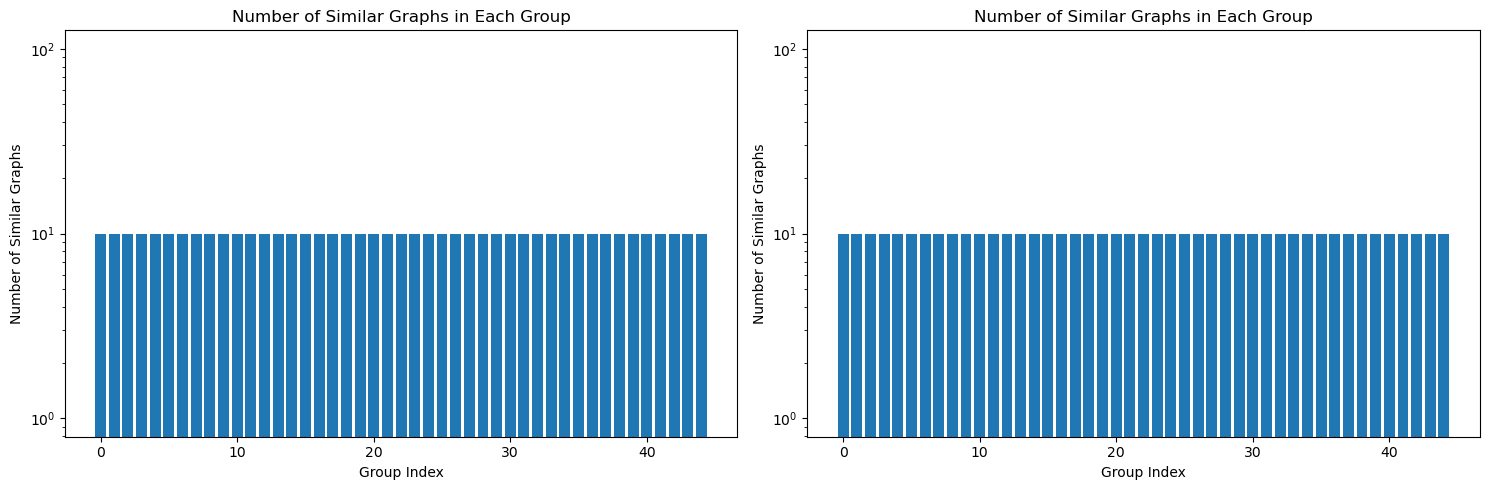

In [7]:
num_similar_graph = [len(group) for group in list_of_same_graphs] 
# print("Number of similar graphs for each unique task:", num_similar_graph)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first graph on the first subplot
axs[0].bar(range(len(num_similar_graph)), num_similar_graph)
axs[0].set_yscale('log')
axs[0].set_xlabel('Group Index')
axs[0].set_ylabel('Number of Similar Graphs')
axs[0].set_title('Number of Similar Graphs in Each Group')

# Plot the second graph on the second subplot
num_similar_graph = num_similar_graph[0:50]
axs[1].bar(range(len(num_similar_graph)), num_similar_graph)
axs[1].set_yscale('log')
axs[1].set_xlabel('Group Index')
axs[1].set_ylabel('Number of Similar Graphs')
axs[1].set_title('Number of Similar Graphs in Each Group')

plt.tight_layout()
plt.show()

Index of the group with the maximum occurrences: 0


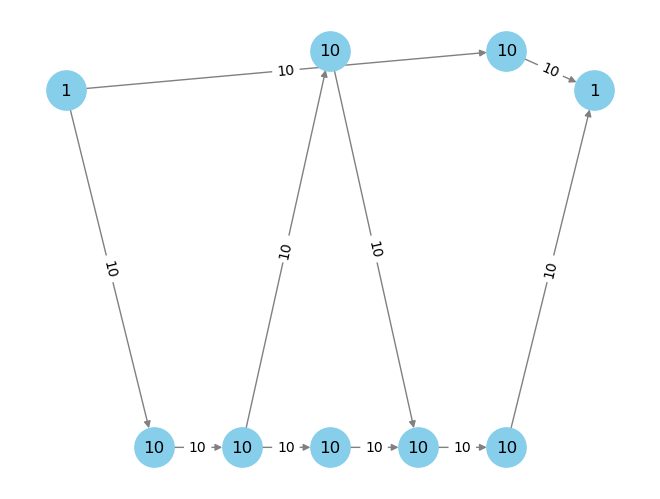

Min: 2089.0, Max: 2390.0
25th Percentile 2098.25
75th Percentile 2314.0
Inter quartile range: 215.75


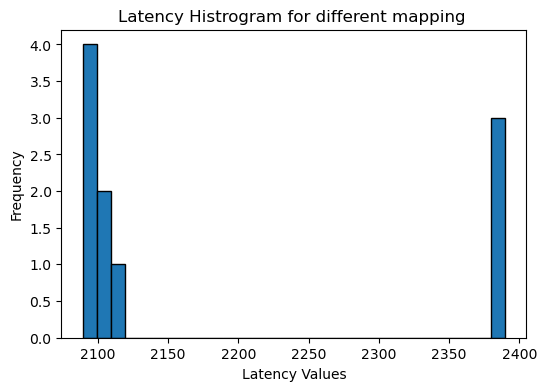

In [22]:
max_occurrences_index = num_similar_graph.index(max(num_similar_graph))
print("Index of the group with the maximum occurrences:", max_occurrences_index)

most_freq_graph_list = list_of_same_graphs[max_occurrences_index]

import numpy as np

def plot_latency_histogram(graph_list, fig_width=6, fig_height=4):
    latency_list = []

    for task in graph_list:
        latency = task['network_processing_time']
        latency_list.append(float(latency))

    q1 = np.percentile(latency_list, 25)
    q2 = np.percentile(latency_list, 75)

    print(f"Min: {np.min(latency_list)}, Max: {np.max(latency_list)}")
    print(f"25th Percentile {q1}")
    print(f"75th Percentile {q2}")
    print(f"Inter quartile range: {q2-q1}")

    plt.figure(figsize=(fig_width, fig_height))
    plt.hist(latency_list, bins=30, edgecolor='black')
    plt.title('Latency Histrogram for different mapping ')
    plt.xlabel('Latency Values')
    plt.ylabel('Frequency')
    plt.show()

index = 40
list_of_same_graphs[index][0]['task_dag'].plot()
plot_latency_histogram(list_of_same_graphs[index])
